In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)

# ----------------------------
# CNN Classifier
# ----------------------------
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128x128

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64x64

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# ----------------------------
# Training Setup
# ----------------------------
model = CNNClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 150
train_losses = []
train_accuracies = []
test_accuracies = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Evaluation on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_acc = 100. * correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Loss: {running_loss:.4f}")

# ----------------------------
# Plot Accuracy and Loss
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()


Epoch [1/150] | Train Acc: 50.00% | Test Acc: 50.00% | Loss: 3.9191
Epoch [2/150] | Train Acc: 50.00% | Test Acc: 51.22% | Loss: 2.0910
Epoch [3/150] | Train Acc: 81.71% | Test Acc: 48.78% | Loss: 2.0425
Epoch [4/150] | Train Acc: 67.07% | Test Acc: 50.00% | Loss: 1.9535
Epoch [5/150] | Train Acc: 52.44% | Test Acc: 48.78% | Loss: 1.8065
Epoch [6/150] | Train Acc: 95.12% | Test Acc: 60.98% | Loss: 1.4144
Epoch [7/150] | Train Acc: 95.12% | Test Acc: 48.78% | Loss: 0.9298
Epoch [8/150] | Train Acc: 91.46% | Test Acc: 52.44% | Loss: 0.7001
Epoch [9/150] | Train Acc: 100.00% | Test Acc: 48.78% | Loss: 0.2576
Epoch [10/150] | Train Acc: 100.00% | Test Acc: 50.00% | Loss: 0.1262
Epoch [11/150] | Train Acc: 100.00% | Test Acc: 50.00% | Loss: 0.0420
Epoch [12/150] | Train Acc: 100.00% | Test Acc: 50.00% | Loss: 0.0166
Epoch [13/150] | Train Acc: 100.00% | Test Acc: 53.66% | Loss: 0.0024
Epoch [14/150] | Train Acc: 100.00% | Test Acc: 52.44% | Loss: 0.0028
Epoch [15/150] | Train Acc: 100.00% |

[Epoch 0/200] [Batch 0/3] [D loss: 0.25671330094337463] [G loss: 0.3204300105571747]
[Epoch 1/200] [Batch 0/3] [D loss: 0.24985724687576294] [G loss: 0.3308037519454956]
[Epoch 2/200] [Batch 0/3] [D loss: 0.21580415964126587] [G loss: 0.31354570388793945]
[Epoch 3/200] [Batch 0/3] [D loss: 0.1912383735179901] [G loss: 0.3230702877044678]
[Epoch 4/200] [Batch 0/3] [D loss: 0.24627801775932312] [G loss: 0.3268875777721405]
[Epoch 5/200] [Batch 0/3] [D loss: 0.19245101511478424] [G loss: 0.33245083689689636]
[Epoch 6/200] [Batch 0/3] [D loss: 0.24125775694847107] [G loss: 0.3462412655353546]
[Epoch 7/200] [Batch 0/3] [D loss: 0.1620272397994995] [G loss: 0.3534388244152069]
[Epoch 8/200] [Batch 0/3] [D loss: 0.15919053554534912] [G loss: 0.3562827706336975]
[Epoch 9/200] [Batch 0/3] [D loss: 0.16346663236618042] [G loss: 0.36542898416519165]
[Epoch 10/200] [Batch 0/3] [D loss: 0.1400732696056366] [G loss: 0.37165194749832153]
[Epoch 11/200] [Batch 0/3] [D loss: 0.16160790622234344] [G los

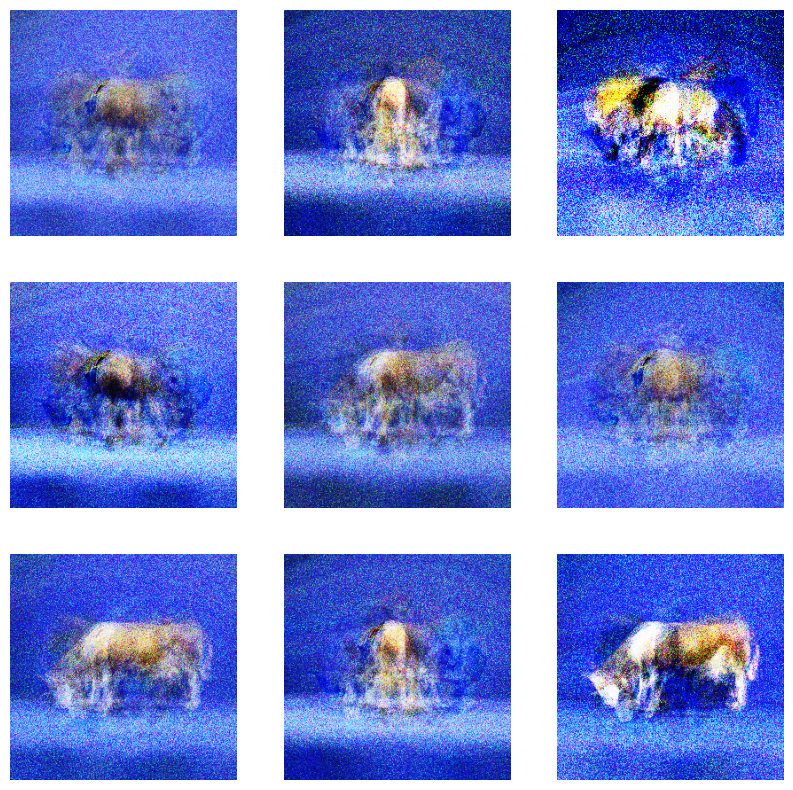

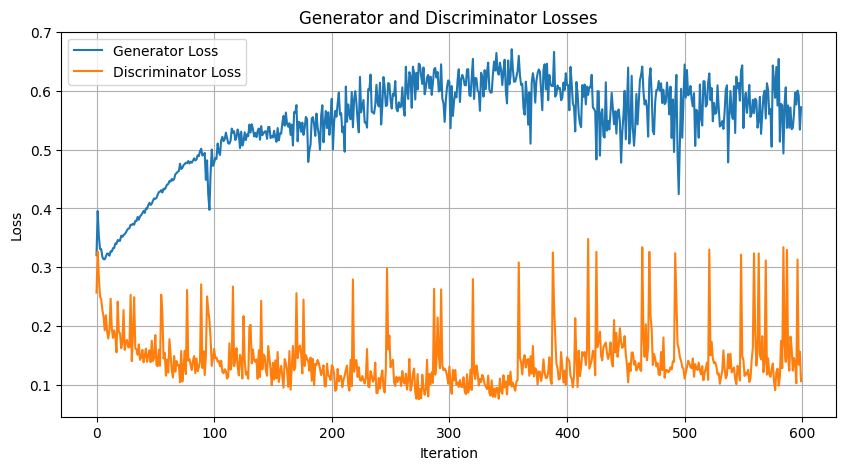

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

torch.cuda.empty_cache()

# Set device
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----------------------------
# GAN Generator
# ----------------------------
class Generator(nn.Module):
    def __init__(self, z_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# ----------------------------
# GAN Discriminator
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# ----------------------------
# GAN Training Setup
# ----------------------------
z_dim = 20
img_shape = (3, 256, 256)

generator = Generator(z_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

criterion = nn.MSELoss()  # Least Squares GAN loss
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

num_epochs_gan = 200
batch_size = 32

# Lists to store losses
g_losses = []
d_losses = []

# ----------------------------
# GAN Training Loop
# ----------------------------
for epoch in range(num_epochs_gan):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Generator
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, z_dim).to(device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        g_optimizer.step()

        # Train Discriminator
        d_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_images), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        # Store losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs_gan}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

# Save generated images
z = torch.randn(batch_size, z_dim).to(device)
gen_imgs = generator(z)
gen_imgs = gen_imgs.detach().cpu()
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(gen_imgs[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Denormalize
    plt.axis('off')
plt.show()

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.grid(True)
plt.show()